In [1]:
# Este comando descarga el repositorio entero a una carpeta llamada 'TFMDS' en Colab.
#!git clone https://github.com/jmorala/TFMDS.git

# Inicializar directorios
Clonar repositorio github
Posicionarse en el directorio raíz

In [2]:
import os
import sys

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configurar el directorio de trabajo según el entorno
if IN_COLAB:
    project_dir = '/content/TFMDS'  # Ruta típica en Colab
    os.chdir(project_dir)
else:
    # En VS Code local
    project_dir = r'C:\Users\jmora\Documents\TFMDS'
    os.chdir(project_dir)

# Agregar el directorio del proyecto al path de Python
# (solo si no está ya en el path)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

# Verificación
print("Directorio de trabajo:", os.getcwd())
print("Python path incluye proyecto:", project_dir in sys.path)

Directorio de trabajo: C:\Users\jmora\Documents\TFMDS
Python path incluye proyecto: True


## Lectura de fichero y adaptación de los tipos


In [3]:
import pandas as pd

df_train = pd.read_pickle('datos/df_train.pkl')
df_test = pd.read_pickle('datos/df_test.pkl')

print("\nInformación de las columnas y tipos de datos:")
print(df_train.info())
print(df_test.info())


Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
Index: 625800 entries, 0 to 653482
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idSecuencia         625800 non-null  datetime64[ns]
 1   producto            625800 non-null  int64         
 2   udsVenta            625800 non-null  int64         
 3   bolPromocion        625800 non-null  int64         
 4   bolOpen             625800 non-null  int64         
 5   bolHoliday          625800 non-null  int64         
 6   udsStock            625800 non-null  int64         
 7   rotura_stock        625800 non-null  bool          
 8   anio_mes            625800 non-null  period[M]     
 9   dia_semana          625800 non-null  int32         
 10  mes                 625800 non-null  int32         
 11  trimestre           625800 non-null  int32         
 12  lag_ventas_1        625800 non-null  float64

# Métodos de ML de forecasting 
- Random Forests
- Modelos GBDT: Han sido casi todas las entradas ganadoras en las competiciones de series temporales recientes de Kaggle:
- - XGBoost
- - LightGBM

# Random Forests (RF)

- Determinar características utilizar FEATURES
- Descomponer serie en Train y Test
- Características a Normalizar/Estandarizar o codificar
- Crear modelos estimando hiperparámetros
- Valorar modelos




In [4]:
# Eliminar días que la tienda está cerrada bolOpne == 0 ya que en modelos tipo Random Forest no aportan nada
df_train = df_train[df_train['bolOpen'] == 1].copy()
df_test = df_test[df_test['bolOpen'] == 1].copy()

# Preparación de datos

In [5]:
# ============================================================================
# PREPARACIÓN DE DATOS
# Determinar carqacterísticas (features) y variable objetivo (target)
# ============================================================================
# Características y variable objetivo no incuir las de fecha idSecuencia, bolOpen no hace falta y producto (ya está codificado)
FEATURES = [
    'producto_encoded', 'bolPromocion', 'bolHoliday', 'Cluster',
    'dia_semana', 'mes', 'trimestre',
    'lag_ventas_1', 'lag_ventas_2', 'lag_ventas_3', 'lag_ventas_4',
    'lag_ventas_5', 'lag_ventas_6', 'lag_ventas_7',
    'media_mes_anterior', 'EWMA_corto', 'EWMA_largo', 'Tendencia_EWMA'
]

TARGET = 'udsVenta'

# Random ForestF global

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Importar las funciones de las librerías personalizadas
from lib.metricas import calcular_metricas, comparar_metricas, resumen_metricas, agregar_estadisticas_error
from lib.graficos import (grafico_real_vs_prediccion, grafico_scatter_prediccion, 
                      grafico_distribucion_error, grafico_feature_importance, dashboard_prediccion)

# ============================================================================
# 1. PREPARACIÓN DE DATOS
# ============================================================================

print("="*80)
print("🔧 PREPARACIÓN DE DATOS")
print("="*80)

# Asumiendo que df_train y df_test ya están cargados
X_train = df_train[FEATURES]
y_train = df_train[TARGET]

X_test = df_test[FEATURES]
y_test = df_test[TARGET]

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ y_test shape: {y_test.shape}")

# ============================================================================
# 2. GRID SEARCH CV - BÚSQUEDA DE HIPERPARÁMETROS
# ============================================================================

print("\n" + "="*80)
print("🔍 BÚSQUEDA DE HIPERPARÁMETROS CON GRIDSEARCHCV")
print("="*80)

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5,7,9],
    'max_features': [None, 3 ,10]
}

# Crear el modelo base
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=3,
    n_jobs=-1
)

# Entrenar GridSearchCV
print("\n🚀 Iniciando búsqueda de hiperparámetros...")
print(f"   Total de combinaciones a probar: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['max_features'])}")
print("   Esto puede tomar varios minutos...\n")

grid_search.fit(X_train, y_train)

# ============================================================================
# 3. RESULTADOS DE GRID SEARCH
# ============================================================================

resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4))


print("\n" + "="*80)
print("🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*80)
print(f"   n_estimators: {grid_search.best_params_['n_estimators']}")
print(f"   max_depth: {grid_search.best_params_['max_depth']}")
print(f"   max_features: {grid_search.best_params_['max_features']}")
print(f"   Mejor Score CV (neg_MSE): {grid_search.best_score_:.4f}")

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_


🔧 PREPARACIÓN DE DATOS
✅ X_train shape: (521202, 18)
✅ X_test shape: (23244, 18)
✅ y_train shape: (521202,)
✅ y_test shape: (23244,)

🔍 BÚSQUEDA DE HIPERPARÁMETROS CON GRIDSEARCHCV

🚀 Iniciando búsqueda de hiperparámetros...
   Total de combinaciones a probar: 18
   Esto puede tomar varios minutos...

Fitting 3 folds for each of 18 candidates, totalling 54 fits


KeyboardInterrupt: 

In [ ]:

# ============================================================================
# 4. PREDICCIONES
# ============================================================================

print("\n" + "="*80)
print("📊 GENERANDO PREDICCIONES")
print("="*80)

# Predicciones en train y test
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print("✅ Predicciones completadas")

# ============================================================================
# 5. CÁLCULO DE MÉTRICAS
# ============================================================================

print("\n" + "="*80)
print("📈 MÉTRICAS DE EVALUACIÓN")
print("="*80)

# Calcular métricas para train y test
metricas_train = calcular_metricas(y_train, y_train_pred, 'RandomForest_Train')
metricas_test = calcular_metricas(y_test, y_test_pred, 'RandomForest_Test')

# Mostrar resumen
resultados = [metricas_train, metricas_test]
resumen_metricas(resultados)

# Crear DataFrame con métricas
df_metricas = comparar_metricas(resultados, ordenar_por='RMSE')

# ============================================================================
# 6. PREPARAR DATOS PARA VISUALIZACIÓN
# ============================================================================

print("\n" + "="*80)
print("🎨 PREPARANDO VISUALIZACIONES")
print("="*80)

# Agregar predicciones y errores al DataFrame de test
df_test_viz = df_test.copy()
df_test_viz['prediccion'] = y_test_pred
df_test_viz = agregar_estadisticas_error(df_test_viz, TARGET, 'prediccion')

# ============================================================================
# 7. GRÁFICOS GENERALES
# ============================================================================

print("\n📊 Generando gráficos generales...")

# Gráfico de dispersión general
grafico_scatter_prediccion(
    df=df_test_viz,
    col_real=TARGET,
    col_pred='prediccion',
    titulo='Random Forest - Real vs Predicción (Test Set)',
    figsize=(10, 8)
)

# Distribución del error
grafico_distribucion_error(
    df=df_test_viz,
    col_error='error',
    titulo='Distribución del Error de Predicción',
    bins=50,
    figsize=(12, 6)
)

# Feature Importance
grafico_feature_importance(
    modelo=best_rf,
    feature_names=FEATURES,
    top_n=len(FEATURES),  # Mostrar todas las features
    titulo='Importancia de Features - Random Forest',
    figsize=(10, 8)
)

# ============================================================================
# 8. GRÁFICOS POR CLUSTER (UN PRODUCTO DE CADA CLUSTER)
# ============================================================================

print("\n📊 Generando gráficos por cluster (un producto representativo de cada cluster)...")

# Obtener clusters únicos
clusters = sorted(df_test_viz['Cluster'].unique())
print(f"\n   Clusters encontrados: {clusters}")

for cluster in clusters:
    # Filtrar datos del cluster
    df_cluster = df_test_viz[df_test_viz['Cluster'] == cluster].copy()
    
    # Seleccionar un producto representativo (el que tenga más datos)
    producto_counts = df_cluster['producto'].value_counts()
    producto_representativo = producto_counts.index[0]
    
    # Filtrar por ese producto
    df_producto = df_cluster[df_cluster['producto'] == producto_representativo].copy()
    
    # Ordenar por fecha
    df_producto = df_producto.sort_values('idSecuencia')
    
    print(f"\n   📍 Cluster {cluster} - Producto {producto_representativo}")
    print(f"      Registros: {len(df_producto)}")
    
    # Calcular métricas específicas del producto
    metricas_producto = calcular_metricas(
        df_producto[TARGET], 
        df_producto['prediccion'], 
        f'Cluster_{cluster}_Producto_{producto_representativo}'
    )
    
    print(f"      MAE: {metricas_producto['MAE']:.2f}")
    print(f"      RMSE: {metricas_producto['RMSE']:.2f}")
    print(f"      R2: {metricas_producto['R2']:.4f}")
    
    # Gráfico temporal del producto
    grafico_real_vs_prediccion(
        df=df_producto,
        col_fecha='idSecuencia',
        col_real=TARGET,
        col_pred='prediccion',
        titulo=f'Cluster {cluster} - Producto {producto_representativo}: Real vs Predicción',
        figsize=(14, 6)
    )
    
    # Dashboard completo para este producto
    dashboard_prediccion(
        df=df_producto,
        col_fecha='idSecuencia',
        col_real=TARGET,
        col_pred='prediccion',
        modelo=best_rf,
        feature_names=FEATURES,
        titulo_principal=f'Dashboard - Cluster {cluster} | Producto {producto_representativo}',
        figsize=(16, 10)
    )

# ============================================================================
# 9. RESUMEN FINAL
# ============================================================================

print("\n" + "="*80)
print("✅ PROCESO COMPLETADO")
print("="*80)
print("\n📋 Resumen:")
print(f"   • Mejor modelo entrenado con:")
print(f"     - n_estimators: {grid_search.best_params_['n_estimators']}")
print(f"     - max_depth: {grid_search.best_params_['max_depth']}")
print(f"     - max_features: {grid_search.best_params_['max_features']}")
print(f"\n   • Métricas en Test:")
print(f"     - MAE: {metricas_test['MAE']:.2f}")
print(f"     - RMSE: {metricas_test['RMSE']:.2f}")
print(f"     - R2: {metricas_test['R2']:.4f}")
print(f"     - MAPE: {metricas_test['MAPE (%)']:.2f}%")
print(f"\n   • Gráficos generados:")
print(f"     - Scatter plot general")
print(f"     - Distribución del error")
print(f"     - Feature importance")
print(f"     - {len(clusters)} dashboards por cluster")
print("\n" + "="*80)


# Random Forest por Cluster


ENTRENAMIENTO DE MODELOS POR CLUSTER

🔄 Entrenando modelo para Cluster 0...
   ✓ MAE: 1.80 | RMSE: 2.59 | R²: 0.0914

🔄 Entrenando modelo para Cluster 1...
   ✓ MAE: 2.77 | RMSE: 3.60 | R²: 0.1376

🔄 Entrenando modelo para Cluster 2...
   ✓ MAE: 3.61 | RMSE: 5.11 | R²: 0.1939

🔄 Entrenando modelo para Cluster 3...
   ✓ MAE: 1.08 | RMSE: 1.69 | R²: 0.0466

📊 RESUMEN DE MÉTRICAS
   Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
RF Cluster 3 1.0821  2.8453 1.6868 0.0466     55.51     168.02 0.7569   133.24
RF Cluster 0 1.7994  6.6882 2.5862 0.0914     39.21     125.53 0.7434    93.19
RF Cluster 1 2.7692 12.9662 3.6009 0.1376     55.41      99.03 0.7197    72.62
RF Cluster 2 3.6147 26.0839 5.1072 0.1939     72.98      81.65 0.7102    62.94

🏆 Mejor modelo: RF Cluster 3 (RMSE: 1.6868)


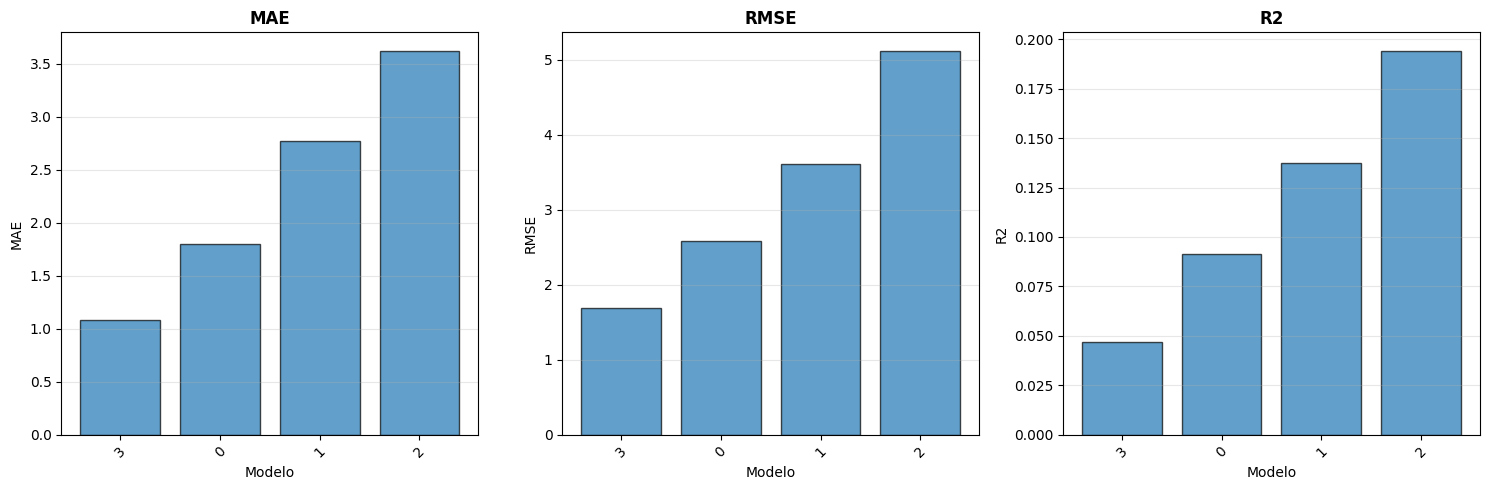

In [7]:
# ============================================================================
# 2. MODELO POR CLUSTERS
# ============================================================================

print("\n" + "="*80)
print("ENTRENAMIENTO DE MODELOS POR CLUSTER")
print("="*80)

modelos_cluster = {}
resultados_cluster = []

for cluster in sorted(df_train_clean['Cluster'].unique()):
    print(f"\n🔄 Entrenando modelo para Cluster {cluster}...")
    
    # Filtrar datos del cluster
    train_cluster = df_train_clean[df_train_clean['Cluster'] == cluster]
    test_cluster = df_test[df_test['Cluster'] == cluster].dropna()
    
    if len(test_cluster) == 0:
        print(f"   ⚠️  No hay datos de validación para Cluster {cluster}")
        continue
    
    # Preparar datos
    X_train = train_cluster[FEATURES]
    y_train = train_cluster[TARGET]
    X_test = test_cluster[FEATURES]
    y_test = test_cluster[TARGET]
    
    # Entrenar Random Forest
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Predecir
    y_pred = rf_model.predict(X_test)
    
    # Guardar modelo
    modelos_cluster[cluster] = rf_model
    
    # Calcular métricas
    metricas = calcular_metricas(y_test, y_pred, f"RF Cluster {cluster}")
    resultados_cluster.append(metricas)
    
    print(f"   ✓ MAE: {metricas['MAE']:.2f} | RMSE: {metricas['RMSE']:.2f} | R²: {metricas['R2']:.4f}")

# Mostrar resumen de resultados por cluster
resumen_metricas(resultados_cluster)

# Comparar métricas por cluster
df_resultados_cluster = comparar_metricas(resultados_cluster, ordenar_por='RMSE')

# Visualizar comparación
grafico_comparacion_metricas(df_resultados_cluster, metricas=['MAE', 'RMSE', 'R2'])



ENTRENAMIENTO DE MODELOS POR PRODUCTO (Top 10)

🏆 Top 10 productos seleccionados: [1, 2, 9, 78, 13, 7, 15, 391, 3, 131]

🔄 Entrenando modelo para Producto 1...
   ✓ MAE: 8.15 | RMSE: 11.55 | R²: -0.0756

🔄 Entrenando modelo para Producto 2...
   ✓ MAE: 4.03 | RMSE: 4.89 | R²: -0.1702

🔄 Entrenando modelo para Producto 9...
   ✓ MAE: 5.17 | RMSE: 5.85 | R²: -0.1119

🔄 Entrenando modelo para Producto 78...
   ✓ MAE: 5.54 | RMSE: 6.78 | R²: 0.1039

🔄 Entrenando modelo para Producto 13...
   ✓ MAE: 3.49 | RMSE: 3.98 | R²: -0.3718

🔄 Entrenando modelo para Producto 7...
   ✓ MAE: 3.02 | RMSE: 3.47 | R²: -0.5599

🔄 Entrenando modelo para Producto 15...
   ✓ MAE: 3.00 | RMSE: 3.89 | R²: 0.0549

🔄 Entrenando modelo para Producto 391...
   ✓ MAE: 3.06 | RMSE: 3.79 | R²: -0.0156

🔄 Entrenando modelo para Producto 3...
   ✓ MAE: 4.38 | RMSE: 5.61 | R²: -0.0394

🔄 Entrenando modelo para Producto 131...
   ✓ MAE: 3.19 | RMSE: 3.84 | R²: 0.0090

📊 RESUMEN DE MÉTRICAS
      Algoritmo    MAE      MSE

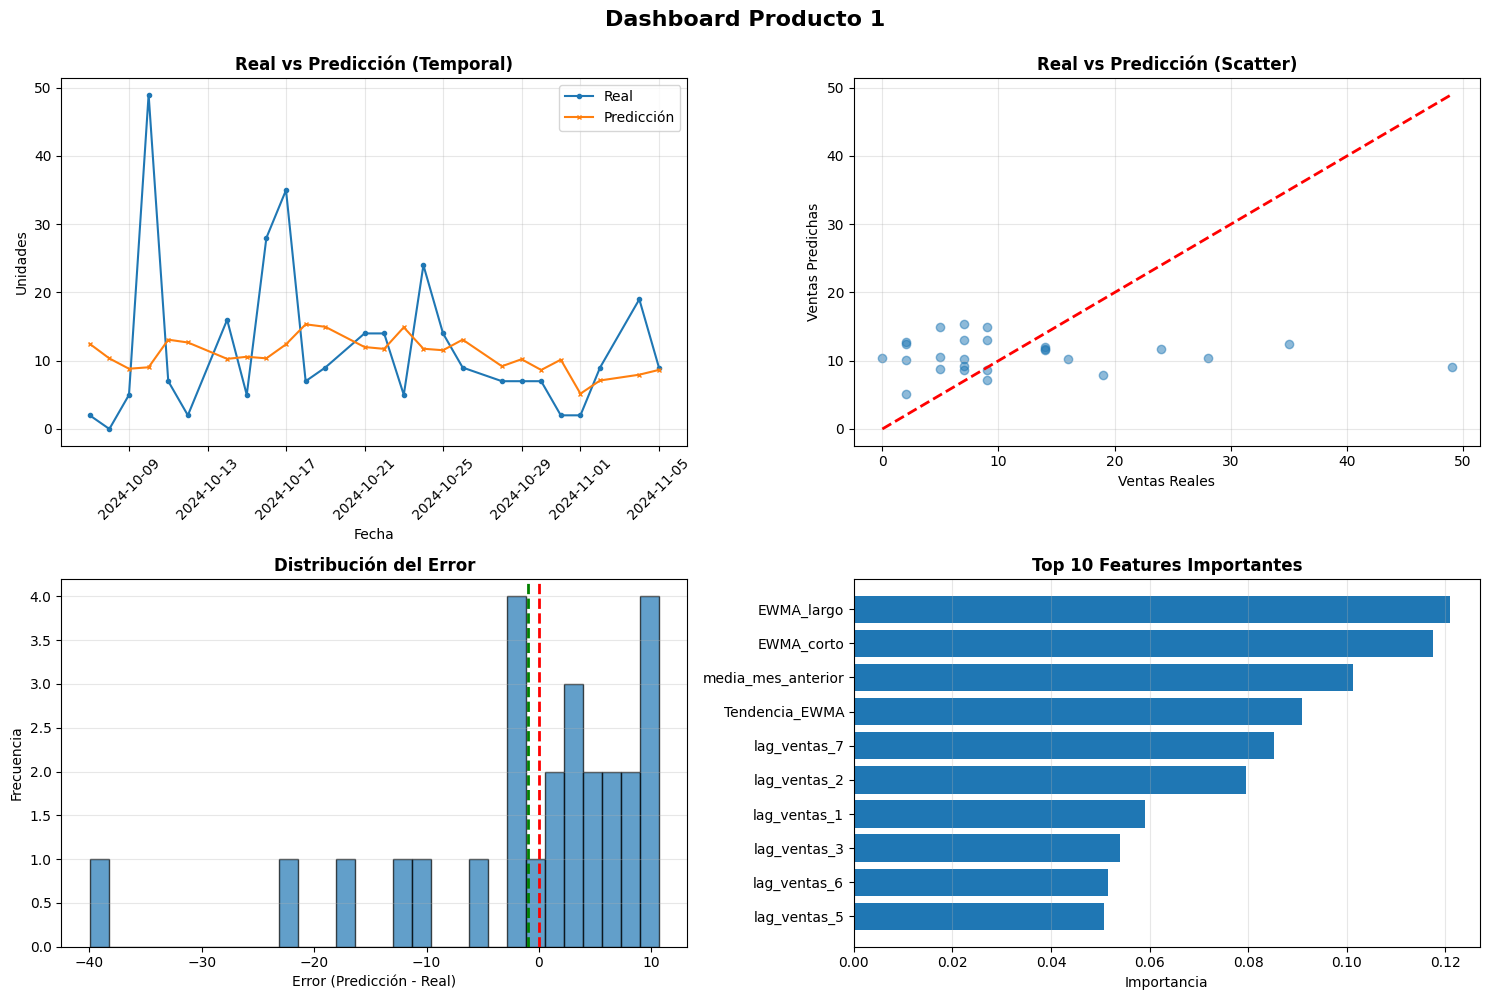


✅ PROCESO COMPLETADO


In [8]:

# ============================================================================
# 3. MODELO POR PRODUCTOS (top 10 productos con más ventas)
# ============================================================================

print("\n" + "="*80)
print("ENTRENAMIENTO DE MODELOS POR PRODUCTO (Top 10)")
print("="*80)

# Identificar top 10 productos con más ventas
top_productos = df_train_clean.groupby('producto')['udsVenta'].sum().nlargest(10).index.tolist()

print(f"\n🏆 Top 10 productos seleccionados: {top_productos}")

modelos_producto = {}
resultados_producto = []

for producto in top_productos:
    print(f"\n🔄 Entrenando modelo para Producto {producto}...")
    
    # Filtrar datos del producto
    train_prod = df_train_clean[df_train_clean['producto'] == producto]
    test_prod = df_test[df_test['producto'] == producto].dropna()
    
    if len(test_prod) == 0:
        print(f"   ⚠️  No hay datos de validación para Producto {producto}")
        continue
    
    if len(train_prod) < 100:
        print(f"   ⚠️  Datos insuficientes para entrenar Producto {producto}")
        continue
    
    # Preparar datos
    X_train = train_prod[FEATURES]
    y_train = train_prod[TARGET]
    X_test = test_prod[FEATURES]
    y_test = test_prod[TARGET]
    
    # Entrenar Random Forest
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Predecir
    y_pred = rf_model.predict(X_test)
    
    # Guardar modelo
    modelos_producto[producto] = rf_model
    
    # Calcular métricas
    metricas = calcular_metricas(y_test, y_pred, f"RF Producto {producto}")
    resultados_producto.append(metricas)
    
    print(f"   ✓ MAE: {metricas['MAE']:.2f} | RMSE: {metricas['RMSE']:.2f} | R²: {metricas['R2']:.4f}")

# Mostrar resumen de resultados por producto
resumen_metricas(resultados_producto)

# Comparar métricas por producto
df_resultados_producto = comparar_metricas(resultados_producto, ordenar_por='RMSE')

# ============================================================================
# 4. ANÁLISIS DETALLADO DE UN PRODUCTO ESPECÍFICO
# ============================================================================

# Seleccionar el primer producto de la lista para análisis detallado
producto_analisis = top_productos[0]

print("\n" + "="*80)
print(f"ANÁLISIS DETALLADO: Producto {producto_analisis}")
print("="*80)

# Obtener predicciones
test_prod = df_test[df_test['producto'] == producto_analisis].dropna().copy()
X_test_prod = test_prod[FEATURES]
y_test_prod = test_prod[TARGET]

y_pred_prod = modelos_producto[producto_analisis].predict(X_test_prod)

# Agregar predicciones y calcular errores
test_prod['prediccion'] = y_pred_prod
test_prod = agregar_estadisticas_error(test_prod, 'udsVenta', 'prediccion')

# Mostrar primeras filas
print(f"\n📋 Primeras predicciones para Producto {producto_analisis}:")
cols_mostrar = ['idSecuencia', 'udsVenta', 'prediccion', 'error', 'error_abs']
print(test_prod[cols_mostrar].head(10).to_string(index=False))

# Estadísticas del error
print(f"\n📊 Estadísticas del error:")
print(f"   Error medio:              {test_prod['error'].mean():.2f}")
print(f"   Error absoluto medio:     {test_prod['error_abs'].mean():.2f}")
print(f"   Error máximo:             {test_prod['error_abs'].max():.2f}")
print(f"   Desviación estándar:      {test_prod['error'].std():.2f}")

# ============================================================================
# 5. VISUALIZACIONES
# ============================================================================

# Dashboard completo para el producto analizado
dashboard_prediccion(
    df=test_prod,
    col_fecha='idSecuencia',
    col_real='udsVenta',
    col_pred='prediccion',
    modelo=modelos_producto[producto_analisis],
    feature_names=FEATURES,
    titulo_principal=f'Dashboard Producto {producto_analisis}'
)

# Gráficos individuales adicionales si se desean
# grafico_real_vs_prediccion(test_prod, 'idSecuencia', 'udsVenta', 'prediccion')
# grafico_scatter_prediccion(test_prod, 'udsVenta', 'prediccion')
# grafico_distribucion_error(test_prod, 'error')
# grafico_feature_importance(modelos_producto[producto_analisis], FEATURES, top_n=15)

print("\n" + "="*80)
print("✅ PROCESO COMPLETADO")
print("="*80)